# **画像分類器を訓練する**
ここでは具体的なデータを使用して実際に画像分類器を作成し、訓練を行います.

本節は [Pytorch公式Tutorial:TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) をベースに作成されています。

## **1 データについて**

ここまでに Neural Network(NN) の定義の仕方，損失計算の仕方，重みの更新の仕方を見てきました．
しかし実際にNNで学習を行うためにはデータを用意しなければなりません．


一般に，画像，テキスト，音声またはビデオデータを扱う際，データをnumpy配列に読み込む以下の様な python パッケージが使用できます．


*   画像については，Pillow, OpenCV など．
*   音声については，scipy と librosa など．
*   テキストについては，単純に Python や Cython ベースの読み込み，または NLTK と SpaCy など．


これらの方法でデータをnumpy 配列に読み込んだ後，PyTorchで扱うために torch.Tensor に変換することができます．

### **1.1 torchvision**
ここでは特に画像データについて扱います．画像データに関してPyTorchではtorchvisionというパッケージが用意されており，画像の読み込みや変換を簡潔に行うことができます．またImageNet，CIFAR-10，MNIST 等の一般的なデータセットを素早く扱うこともできます．

### **1.2 CIFAR-10**
CIFAR-10を使用して実際に画像分類器を作成、訓練します．

CIFAR-10は‘飛行機’, ‘自動車’, ‘鳥’, ‘猫’, ‘鹿’, ‘犬’, ‘蛙’, ‘馬’, ‘船’, ‘トラック’ の10クラスについてサイズ 3x32x32の画像を集めたデータセットです．32×32 pixelのカラー画像(3チャンネル画像)を扱うことになります．（図は[PyTorch公式チュートリアル](https://pytorch.org/tutorials/)より引用）

<img src="https://pytorch.org/tutorials/_images/cifar10.png" width=500>

In [ ]:
from google.colab import drive # driveを接続
drive.mount('/content/drive')

# drive中の課題ファイルのあるディレクトリに移動
%cd /content/drive/MyDrive/FAI20220607

## **2 画像分類器の訓練**

### **2.1 CIFAR-10の読み込みと正規化**
torchvisionを使用してCIFAR-10を読み込みます．

In [31]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision から読み込む CIFAR-10 は値が [0, 1] に調整された PILImage 画像です．PILImage 画像とは画像処理ライブラリであるPillowで扱われる形式の画像です．

それらを NN に入力するために値が [-1, 1] の正規化された torch.Tensor に変換します．

以下のコードを実行するとCIFAR-10がダウンロードされ，正規化され，torch.Tensor に変換されます．

In [127]:
#変換器の作成
#transforms.Composeによって複数の変換を組み合わせ、データを読み込む際に使用するデータ変換器を作成します．
#ここではPILImageをtorch.Tensorに変換したのち正規化を行う変換器を作成します．
transform = transforms.Compose(
    [transforms.ToTensor(),  # torch.Tensor へ変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 正規化する
 
#訓練データのダウンロードと変換
#扱うデータの集合であるデータセットを作成します．
#データは読み込まれる際に変換器によって変換され取り出されます．
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#訓練データのローダ(読み込み器)の作成
#データセットからデータを読み込むローダを作成します．
#ローダを挟むことで同時に幾つのデータを読み込むか、順番に読み込むかランダムに読み込むかなどデータの読み込み方を容易に設定できます．
#またnum_workersの指定によってデータ読み込みの並列化を容易に実現できます．
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)
 
#テストデータのダウンロードと変換
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#テストデータのローダ(読み込み器)の作成
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ダウンロードした画像をいくつか表示してみます．

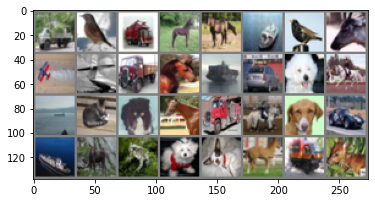

truck  bird truck horse


In [128]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # [-1,1] を [0,1] へ戻す(正規化解除)
    npimg = img.numpy()  # torch.Tensor から numpy へ変換
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # チャンネルを最後に並び変える((C,X,Y) -> (X,Y,C))
    plt.show()  # 表示


# 訓練用画像を取得する
# pythonでは順番にデータを取得する際にイテレータと呼ばれるオブジェクトが介在します．
# ローダを使用してデータを読み込む際もイテレータを使用します．
dataiter = iter(trainloader)  # ローダを使って実際にデータを取得するためのイテレータを作成する．
images, labels = dataiter.next()  # イテレータからデータを取得する．

# 画像を表示する．
imshow(torchvision.utils.make_grid(images))
# ラベル(クラス)を表示する．
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### **2.2 Convolutional Neural Network (CNN) を定義する**

以前に定義した NN をコピーして，1チャネル画像(白黒)の替わりに3チャネル画像(カラー)を扱えるよう変更します．

In [139]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, in_c):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_c,in_c,3,1,1,bias =False)
        self.bn1 = nn.BatchNorm2d(in_c)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_c, in_c*2, 3,2,1,bias =False)
        self.bn2 = nn.BatchNorm2d(in_c*2)
        self.conv3 = nn.Conv2d(in_c, in_c*2,1,2,0, bias =False)

    def forward(self, x):
 

        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        identity = self.conv3(identity)
        x = x + identity
        x = self.relu(x)

        return x


class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3, bias = False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(3,1,1)
        self.relu = nn.ReLU()
        self.net1 = Net(64)
        self.net2 = Net(128)
        self.net3 = Net(256)

        self.linear = nn.Linear(512*2*2, 10)
        
    def forward(self, x):
  
        x = self.conv1(x)
    
        x = self.bn1(x)
       
        x = self.maxpool(x)
      
        x = self.relu(x)
   
        x = self.net1(x)
    
        x = self.net2(x)
     
        x = self.net3(x)
       
        x = self.maxpool(x)
       
        x = torch.flatten(x,1)
        x = self.linear(x)

        return x

net = ResNet()

### **2.3 損失関数と optimizer を定義する**
分類問題でよく使用される Cross-Entropy 損失と慣性項（momentum）を持つ SGD を使用します．

In [140]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

net.apply(init_weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (net1): Net(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
  )
  (net2): Net(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (conv2)

### **2.4 ネットワークを訓練する**
CNN の訓練を開始します．データをローダから単純にループで取得し，ネットワークに入力して最適化を行います．

以下のコードを実行すると訓練が始まります（数分かかります）．

In [141]:
net.to(0)
net.train()
for epoch in range(2):  # 訓練データを複数回(2周分)学習する
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # ローダからデータを取得する; データは [inputs, labels] の形で取得される．
        # イテレータを使用していないように見えますが for の内部で使用されています．
        inputs, labels = data
        inputs, labels = inputs.to(0), labels.to(0)
        # 勾配を0に初期化する(逆伝播に備える)．
        optimizer.zero_grad()

        # 順伝播 + 逆伝播 + 最適化(訓練)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 統計を表示する．
        running_loss += loss.item()
        if i % 2000 == 1999:    # 2000 ミニバッチ毎に表示する．
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


順調に学習が進めば損失の減少が確認できます.

訓練されたネットワーク(のパラメタ)を保存します．

In [142]:
# net.state_dict()によってネットワークの全パラメタ(重み)を格納した辞書を取得し，torch.saveで保存します．
# パラメタ(重み)でなくネットワークを丸ごと保存することも可能ですが、後々不便になることが多いです．
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### **2.5 テストデータでネットワークをテストする**
ネットワークを訓練データ2周分学習しました．しかしネットワークが本当に汎化的に学習したかどうかをテストデータで調べる必要があります．

ネットワークにテストデータを入力した際に出力（予測）されるクラスラベルを正解と比較することで汎化性能のテストを行います．予測が正しければ、サンプルを正解のリストに追加します．

まずはテストデータをいくつか表示してみます．

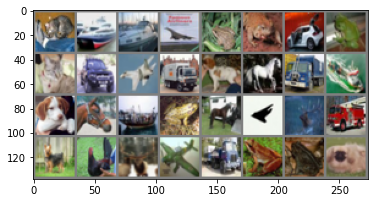

GroundTruth:    cat  ship  ship plane


In [143]:
# テストデータを取得
dataiter = iter(testloader)
images, labels = dataiter.next()

# 画像を表示
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

次に，先ほど保存したネットワーク（のパラメタ）をロードします（本来ここでは必要ありませんが例示のため行います）．

In [144]:
net = ResNet()  # ネットワークを再生成する（学習前の初期化されたネットワークになる）．
net.load_state_dict(torch.load(PATH))  # 保存しておいた学習後のパラメタ（重み）を読み込む．

<All keys matched successfully>

ここで学習後のパラメタ（重み）をロードしたネットワークにテストデータのラベル（クラス）を予測させてみます．

In [145]:
outputs = net(images)

出力は10クラスそれぞれに対する事後確率となります．クラスに対する事後確率が高いほど，ネットワークは画像がそのクラスに所属する確率が高いと予測しています．そのため最も事後確率の高いインデックス（クラス）を取得することでネットワークの予測とします．

先ほど表示したテストデータに対する予測を見てみます．

In [146]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


学習が上手くいっていればまずまず正しい予測が出るはずです．

次にネットワークがテストデータ全体に対してどの程度正しい予測をするのか確認します．

In [149]:
correct = 0
total = 0
net.eval()
with torch.no_grad():  #勾配計算をしない宣言（逆伝播用の計算グラフを作成しないことでメモリ節約，速度向上する）
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %
68.13


予測精度が 10 % 以上であればネットワークは正しく学習していることになります（10 クラスから無作為に1つのクラスを選択すると精度は 10 %）．

最後に各クラス毎の予測精度を確認してみます．

In [148]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 90 %
Accuracy of  bird : 52 %
Accuracy of   cat : 47 %
Accuracy of  deer : 42 %
Accuracy of   dog : 59 %
Accuracy of  frog : 77 %
Accuracy of horse : 75 %
Accuracy of  ship : 86 %
Accuracy of truck : 70 %
